In [ ]:
# Install the necessary requirement
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Get the dataset
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=6057eaac3495b93e7a4b7b6d98def286e9d03e84b08be54d64ff8666797a4d43
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=9df23841d3dfd073966525e54f2bcb2036a55d474292216a98e450b1c0e54402
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f53

In [ ]:
# Import all necessary pacakge
import sys
import torch
import cv2
import helper
import numpy as np
import pandas as pd
import albumentations as a
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from tqdm import tqdm
from sklearn.model_selection import train_test_split as tts
from torch.utils.data import Dataset, DataLoader
from torch import nn


# Add datasest path to environment
sys.path.append("/content/Human-Segmentation-Dataset-master")

In [ ]:
# Set device to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set Param for training
param = {
    "data_dir": "/content",
    "lr": 0.001,
    "batch_size": 32,
    "epoch": 20,
    "img_size": 256,
    "encoder": "timm-efficientnet-b0",
    "weight": "imagenet"
}

# Input data for training
df_input = pd.read_csv("/content/Human-Segmentation-Dataset-master/train.csv")

# Split the data to training and validation dataset
df_train, df_valid = tts(df_input, test_size = 0.2, random_state = 1)

In [ ]:
# Define an augmentation for each image on train and validation dataset
def augment_train():
  return a.Compose([
      a.Resize(param['img_size'], param['img_size']),
      a.HorizontalFlip(p = 0.5),
      a.VerticalFlip(p = 0.5)
      ], is_check_shapes=False)

def augment_valid():
  return a.Compose([
      a.Resize(param['img_size'], param['img_size'])
  ], is_check_shapes=False)

def show_image(image, mask):
  # Plot the figure
  fig, (ax1, ax2)= plt.subplots(nrows = 1, ncols = 2 , figsize = (20,10))
  ax1.set_title("Image")
  ax1.imshow(img)
  ax2.set_title("Mask")
  ax2.imshow(mask)


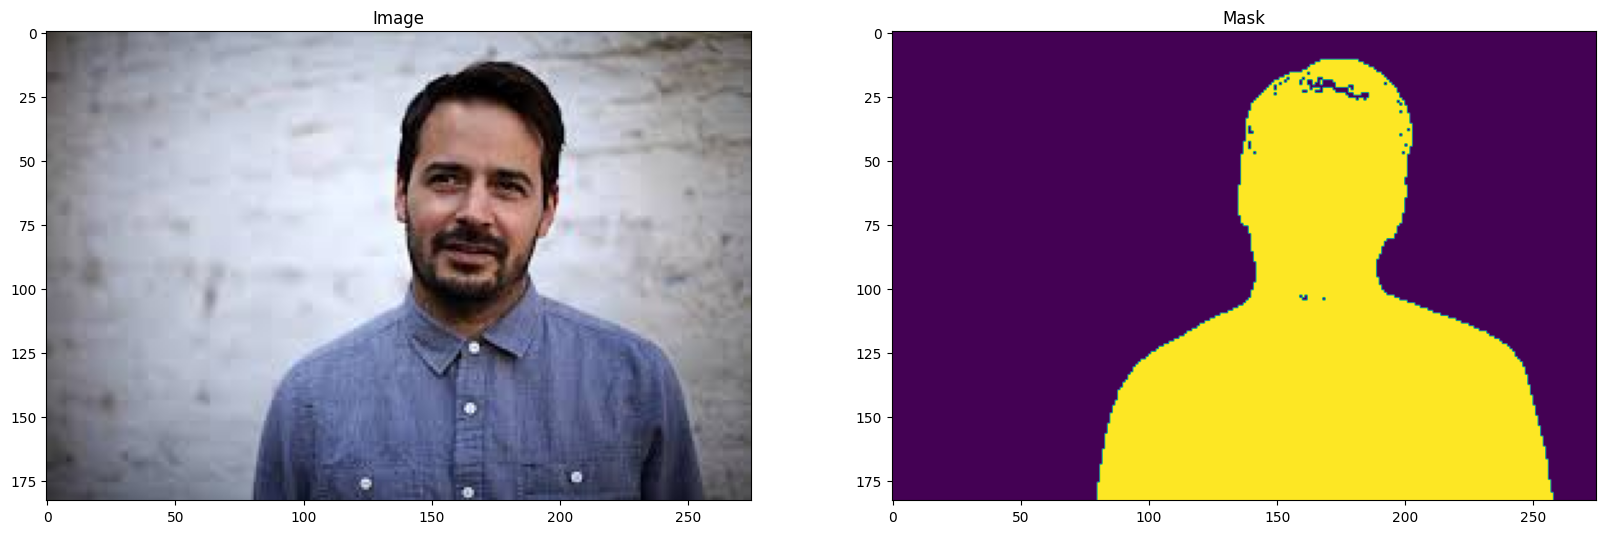

In [ ]:
# Take a look of the input data

# Take the data path from dataframe
img_path = df_train['images'][1]
mask_path = df_train['masks'][1]

# Read image and change image color form BGR to RGB
img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Read mask in grayscale
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Show Image
show_image(img, mask)

In [ ]:
# Create dataset using torch
class DatasetSegmentation(Dataset):
  def __init__(self, df, augment):
    self.df = df
    self.augment = augment

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img_path = row.images
    mask_path = row.masks

    # img_path = self.df['images'][idx]
    # mask_path = self.df['masks'][idx]

    # Read image and change image color form BGR to RGB
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    # Read mask in grayscale
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    # print(img.shape, mask.shape)

    if self.augment:
      data = self.augment(image = img, mask = mask)
      img = data['image']
      mask = data['mask']


    # 3 256 256
    # print(img.shape, mask.shape)

    # img = np.transpose(img, (2,0,1)).astype(np.float32)
    # mask = np.transpose(mask, (2,0,1)).astype(np.float32)
    # print(img.shape, mask.shape)

    img = (torch.Tensor(img) / 255.0).permute(2,0,1)
    mask = torch.round(torch.Tensor(mask) / 255.0).permute(2,0,1)

    # 256 256 3
    # img = (torch.Tensor(img) / 255.0).permute(1, 2, 0 )
    # mask = torch.round(torch.Tensor(mask) / 255.0).permute(1, 2, 0 )

    # print(img.shape, mask.shape)
    return img, mask


In [ ]:
# deifne dataset and augmentations
train_set = DatasetSegmentation(df_train, augment_train())
valid_set = DatasetSegmentation(df_valid, augment_valid())

# check train and validation dataset size
print(len(train_set), len(valid_set))

# visualise image and mask after augmentations
img, mask = train_set[3]
print(len(img), len(mask))
# show_image(img, mask)

232 58
3 1


In [ ]:
train_loader = DataLoader(train_set, batch_size=param['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=param['batch_size'])

In [ ]:
len(train_loader), len(valid_loader)

(8, 2)

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
# plt.imshow(label, cmap="gray")
# plt.show()
# print(f"Label: {label}")

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32, 1, 256, 256])


In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.encoder = smp.Unet(
        encoder_name = param["encoder"],
        encoder_weights = param["weight"],
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, img, masks = None):
    logits = self.encoder(img)
    if masks is not None:
      loss_dice = DiceLoss(mode='binary')(logits, masks)
      loss_BCEW = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss_dice + loss_BCEW

    return logits

In [ ]:
def train_segmentation(data_loader, model, optimizer):
  losses = 0
  model.train()
  for img, mask in data_loader:
    img = img.to(device)
    mask = mask.to(device)
    optimizer.zero_grad()

    logits, loss = model(img, mask)

    loss.backward()
    optimizer.step()

    losses += loss.item()
  return losses/len(data_loader)


In [ ]:
def eval_segmentation(data_loader, model):
  losses = 0
  model.eval()
  with torch.no_grad():
    for img, mask in data_loader:
      img = img.to(device)
      mask = mask.to(device)

      logits, loss = model(img, mask)

      losses += loss.item()
  return losses/len(data_loader)


In [ ]:
model = SegmentationModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = param["lr"])
best_eval_loss = np.inf
for i in range(param["epoch"]):
  train_loss = train_segmentation(train_loader, model, optimizer)
  if i % 2 == 0:
    eval_loss = eval_segmentation(valid_loader, model)
  if eval_loss < best_eval_loss:
    torch.save(model.state_dict(), 'best_segment_model.pt')
    best_eval_loss = eval_loss
    print("best model is saved")

  print(f"""
        Epoch {i+1}:
        train_loss: {train_loss},
        eval_loss =  {eval_loss},
        best_eval_loss: {best_eval_loss}
        """
  )


best model is saved

        Epoch 1: 
        train_loss: 0.9114524126052856,
        eval_loss =  3.7969058752059937,
        best_eval_loss: 3.7969058752059937
        

        Epoch 2: 
        train_loss: 0.4482411779463291,
        eval_loss =  3.7969058752059937,
        best_eval_loss: 3.7969058752059937
        
best model is saved

        Epoch 3: 
        train_loss: 0.2971869595348835,
        eval_loss =  0.3824945539236069,
        best_eval_loss: 0.3824945539236069
        

        Epoch 4: 
        train_loss: 0.2407927494496107,
        eval_loss =  0.3824945539236069,
        best_eval_loss: 0.3824945539236069
        
best model is saved

        Epoch 5: 
        train_loss: 0.24456084333360195,
        eval_loss =  0.2361125573515892,
        best_eval_loss: 0.2361125573515892
        

        Epoch 6: 
        train_loss: 0.19025196135044098,
        eval_loss =  0.2361125573515892,
        best_eval_loss: 0.2361125573515892
        
best model is saved

     